In [4]:
# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Introduction to OpenAI gym

In [5]:

import gym

Next we will load the MsPacman enviroment, version 0.

In [6]:
env = gym.make('MsPacman-v0')

Let's initalize the enviroment by calling reset reset() method. This returns an observation:

In [7]:
obs = env.reset()

Observations vary depending on the enviroment. In this case it is a RGB image representedas a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other enviroments it may return different objects, as we can see later.

In [8]:
obs.shape

(210, 160, 3)

In [9]:
img = env.render(mode="rgb_array")

<IPython.core.display.Javascript object>


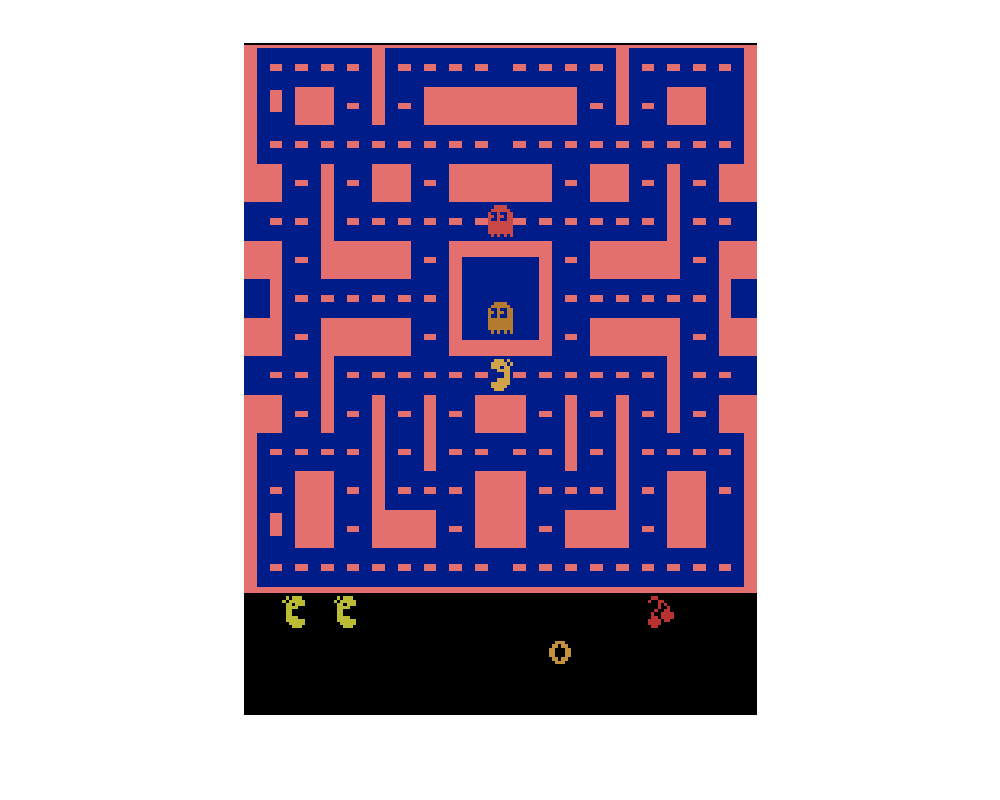

Saving figure MsPacman


In [10]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
save_fig("MsPacman")
plt.show()

Welcome back to the 1980s! :)

In this enviroment, the rendered image is simply equal to the oberservations (but in many enviroments this is not the case).

In [11]:
(img == obs).all()

True

In [12]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [13]:
env.action_space

Discrete(9)

Discrete(9) means that the possible actions are integers 0 through 8, which represents the 9 possible positions of the joystick (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left).

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

In [14]:

env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

<IPython.core.display.Javascript object>


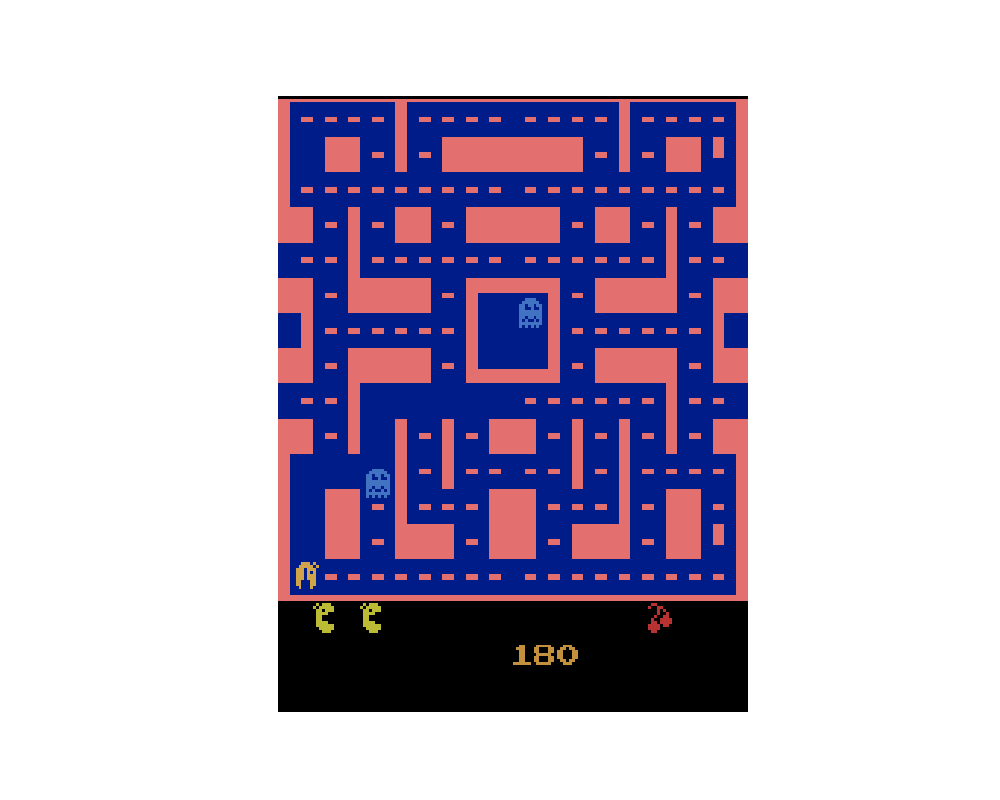

In [15]:
plot_environment(env)

The step() function actually returns several important objects:


In [17]:
obs, reward, done, info = env.step(0)

The observation tells the agent what the enviroment looks like, as discussed earlier. This is a 210x160 RGB image:

In [18]:
obs.shape

(210, 160, 3)

the enviroment also tells the agent how much reward it got during the last step:

In [19]:
reward

0.0

when the game is over, the enviroment returns done=True:

In [20]:
done

False

Finally, info is a enviroment-specific dictionary that can provide some extra information about the internal state of the enviroment. THis is useful for debugging, but your agent should not use this information to learn(Since that would be considered cheating)

In [21]:
info

{'ale.lives': 3}

In [22]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()


for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done: 
        break

In [23]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


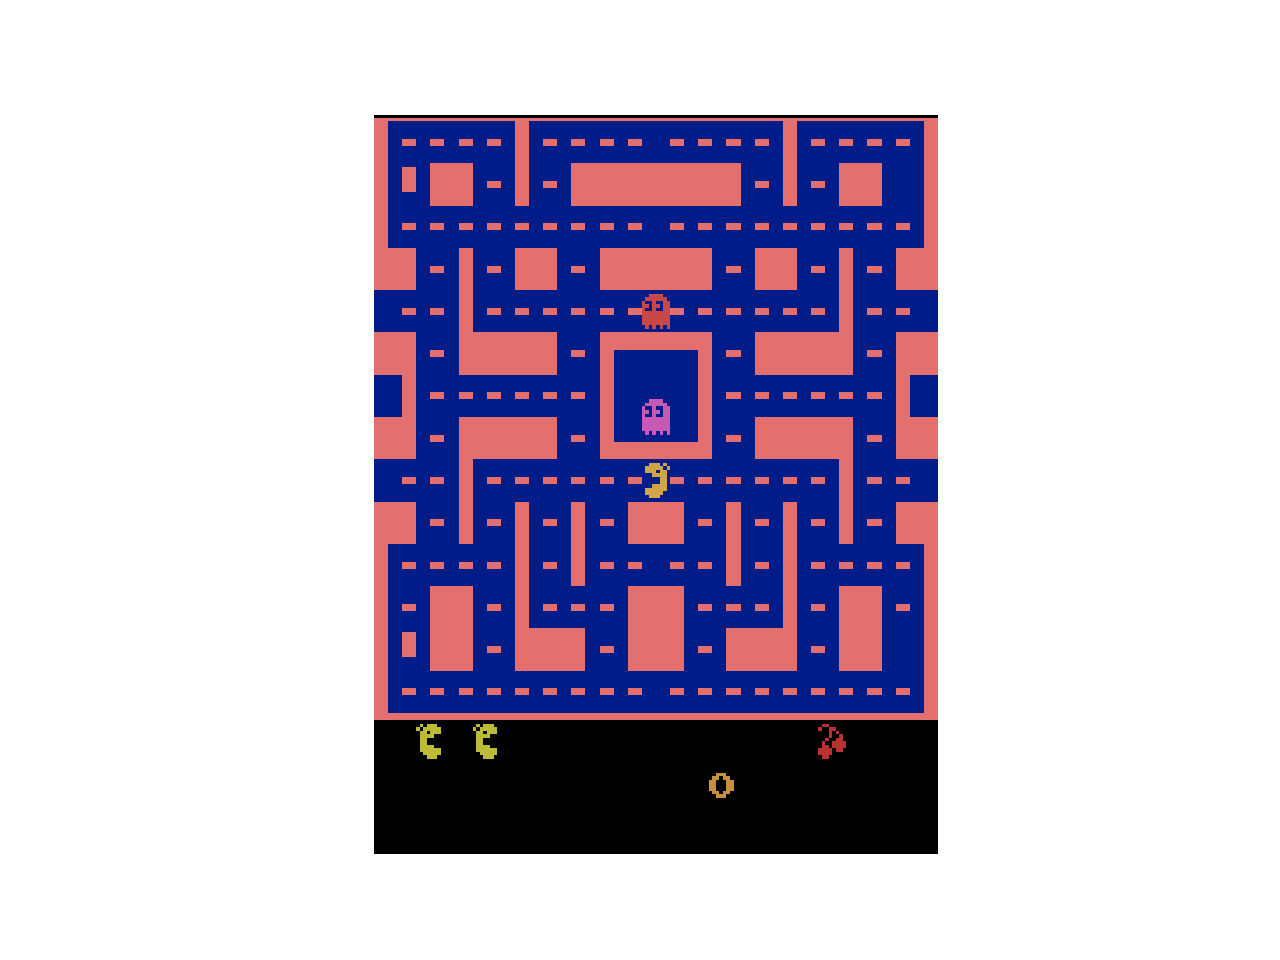

In [24]:
video = plot_animation(frames)
plt.show()

In [28]:
env.close()

## A Simple Enviroment: The Cart-Pole

In [29]:
env = gym.make("CartPole-v0")

In [30]:
obs = env.reset()

In [31]:
obs

array([ 0.02614554, -0.00171903,  0.02895555,  0.00152387])

The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity. Let's render the environment... unfortunately we need to fix an annoying rendering issue first.

## Fixing the Render Issue

In [32]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


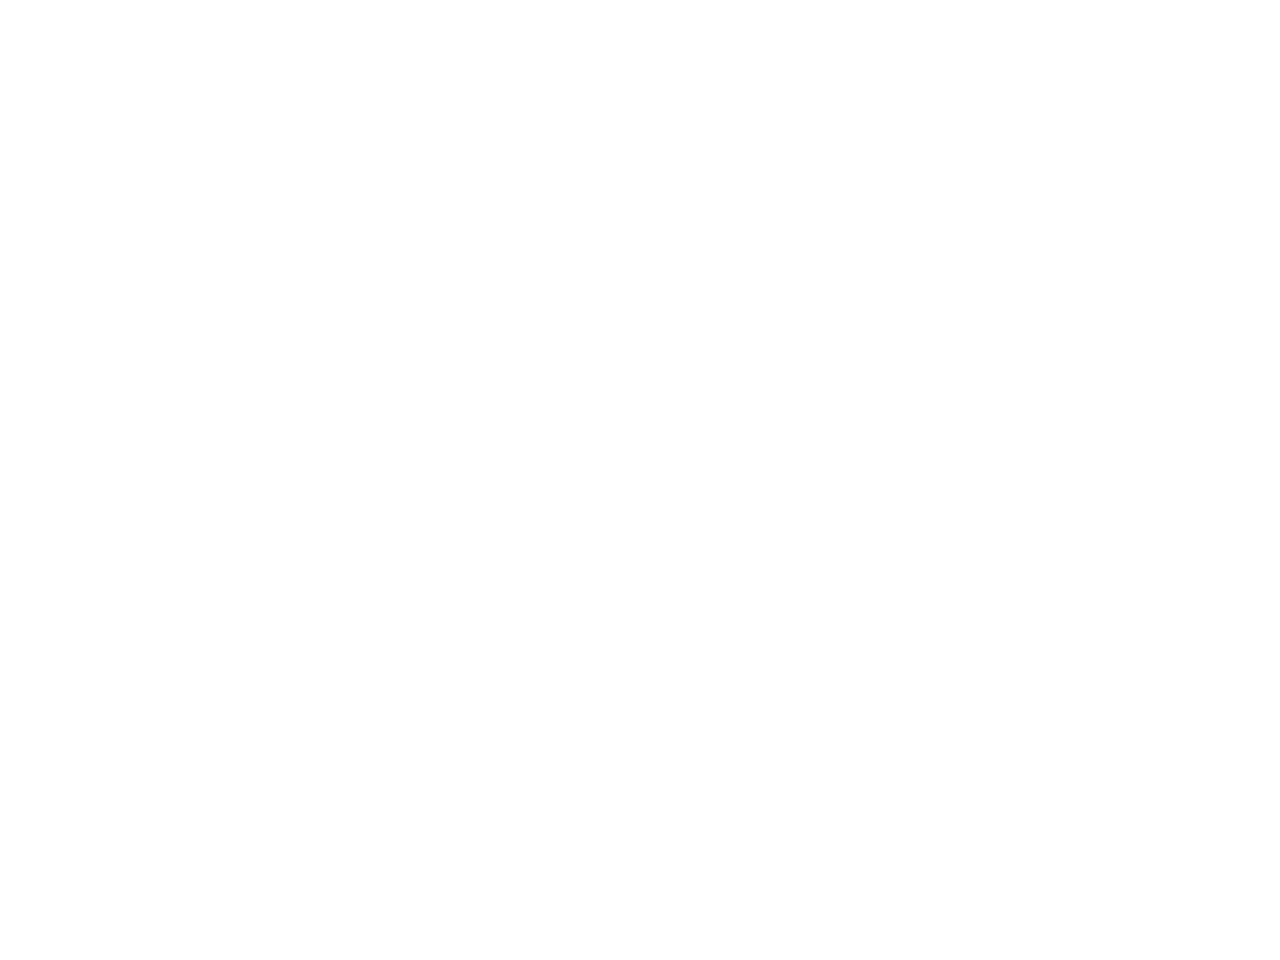

In [33]:
plot_cart_pole(env, obs)

In [34]:
env.action_space

Discrete(2)

In [35]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


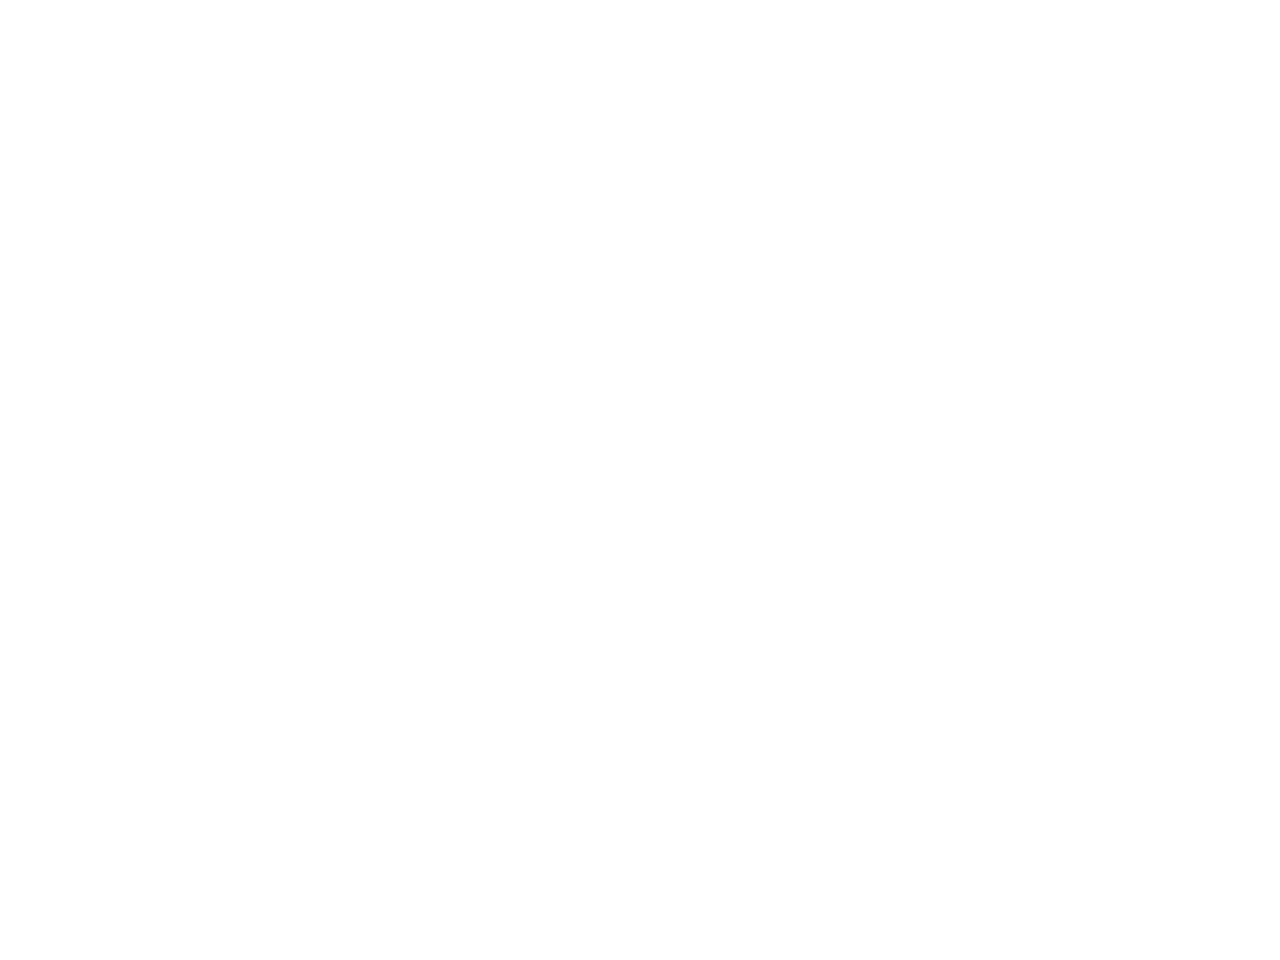

Saving figure cart_pole_plot


In [36]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")
save_fig("cart_pole_plot")

In [37]:

img.shape


(800, 1200, 3)

In [38]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


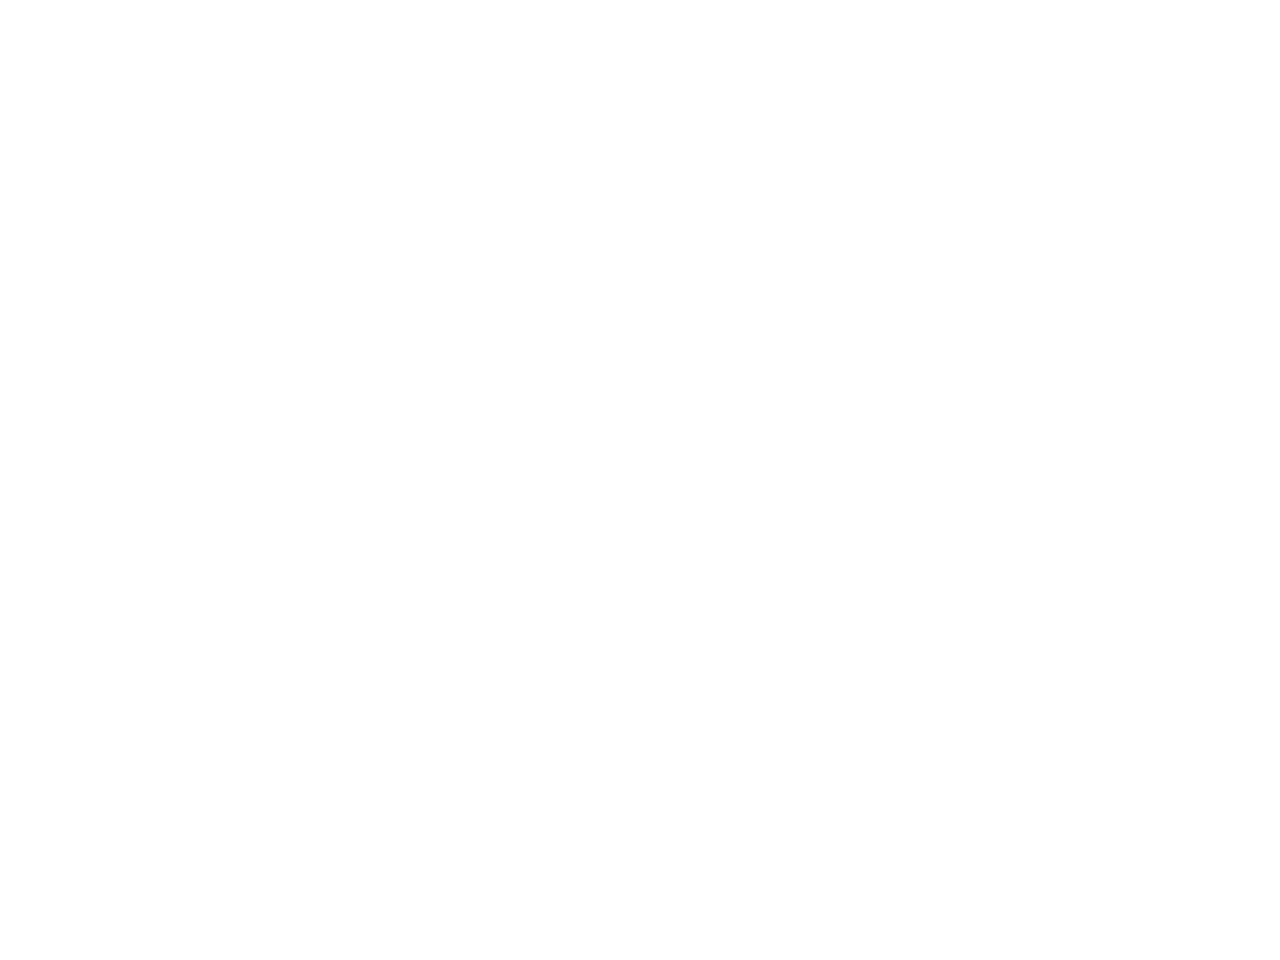

In [39]:
plot_cart_pole(env, obs)



Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a policy for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.


## A simple hard-coded policy


Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and vice versa. Let's see if that works:

In [40]:

frames = []

n_max_steps = 1000
n_change_steps = 100

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

<IPython.core.display.Javascript object>


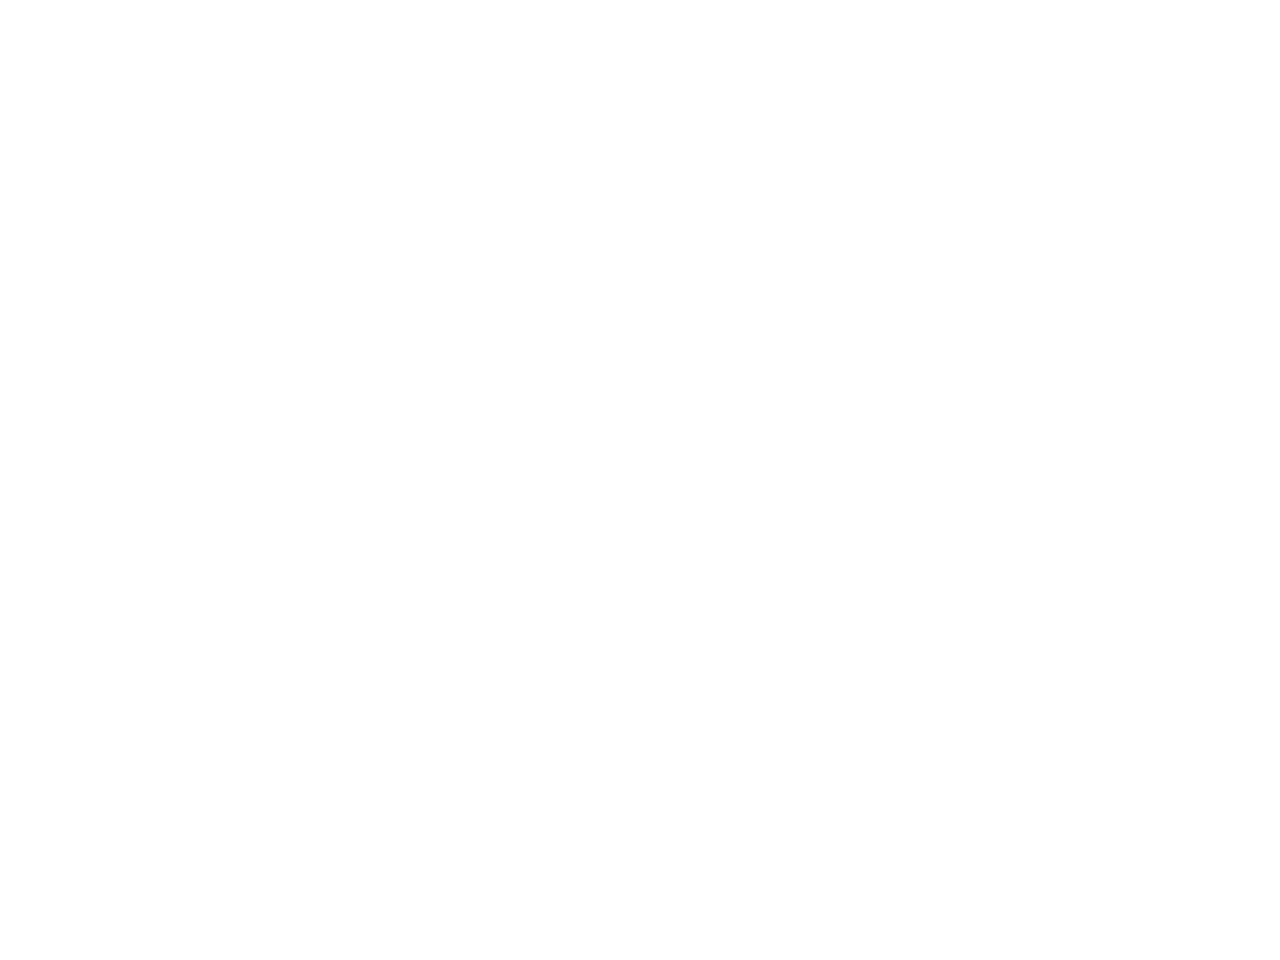

In [45]:
video = plot_animation(frames)
plt.show()


Nope, the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

## Neural Network Policies

In [46]:
import tensorflow as tf

# 1. Specify the network architecture

n_inputs = 4 # == env..observation_space.shape[0]
n_hidden = 4 # it's a simple task, we don't need more than this
n_outputs = 1 # only output the probabilities of accelerating left

initializer = tf.contrib.layers.variance_scaling_initializer()

# 2. Build the neural network

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                        kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis= 1, values=[outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)


init = tf.global_variables_initializer()










In [47]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

<IPython.core.display.Javascript object>


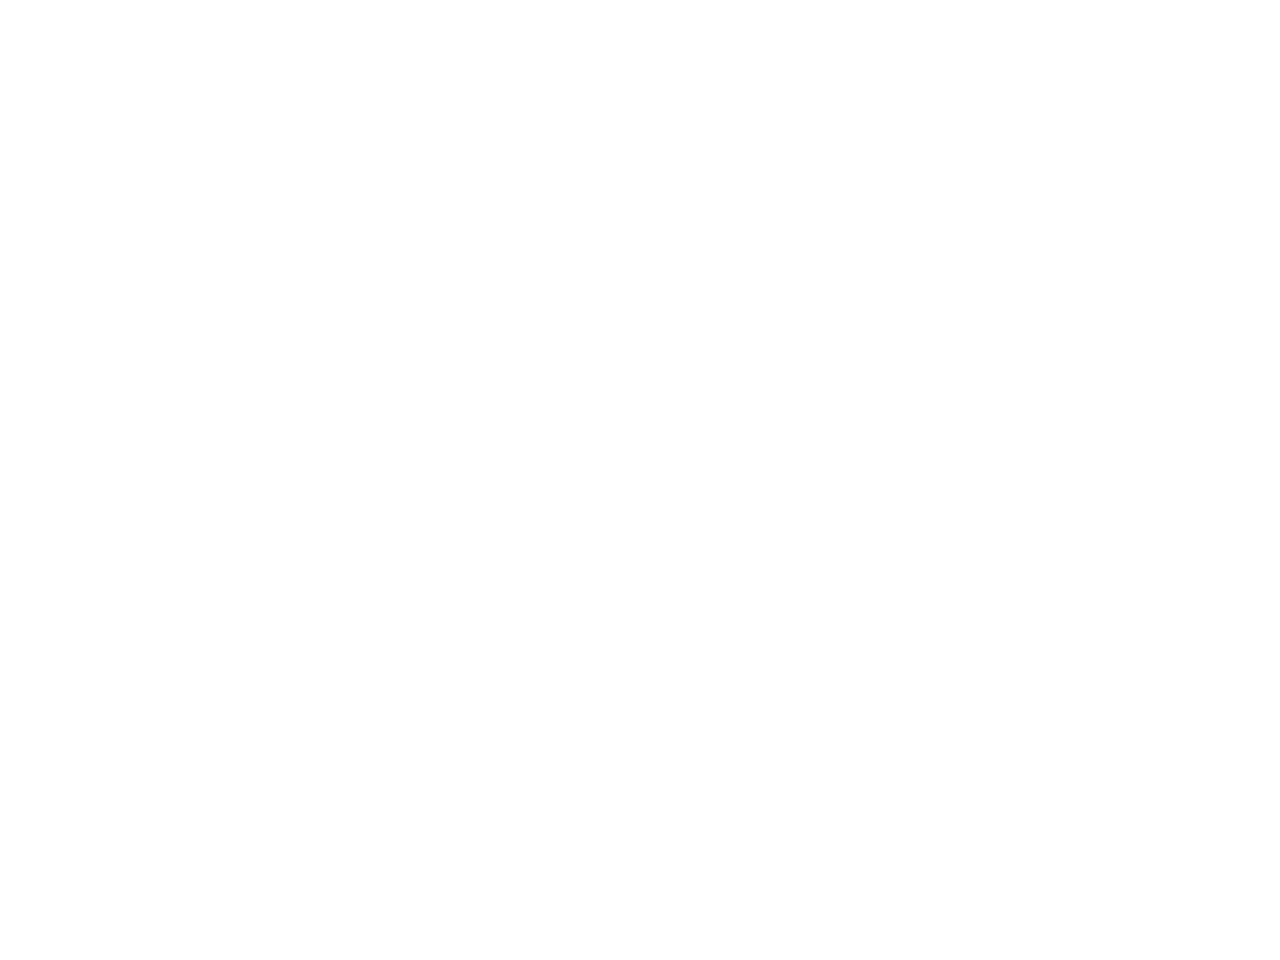

In [48]:
video = plot_animation(frames)
plt.show()


Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right. The following code defines the same neural network but we add the target probabilities y, and the training operations (cross_entropy,  optimizer and training_op):

In [60]:
import tensorflow as tf

In [61]:
tf.reset_default_graph()



n_inputs = 4
n_hidden = 4
n_outputs = 1


learning_rate = 0.01

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
y = tf.placeholder(tf.float32, shape =[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation = tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden,n_outputs)
outputs = tf.nn.sigmoid(logits)
p_left_and_right = tf.concat(axis= 1, values = [outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)


cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)


init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [65]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [66]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


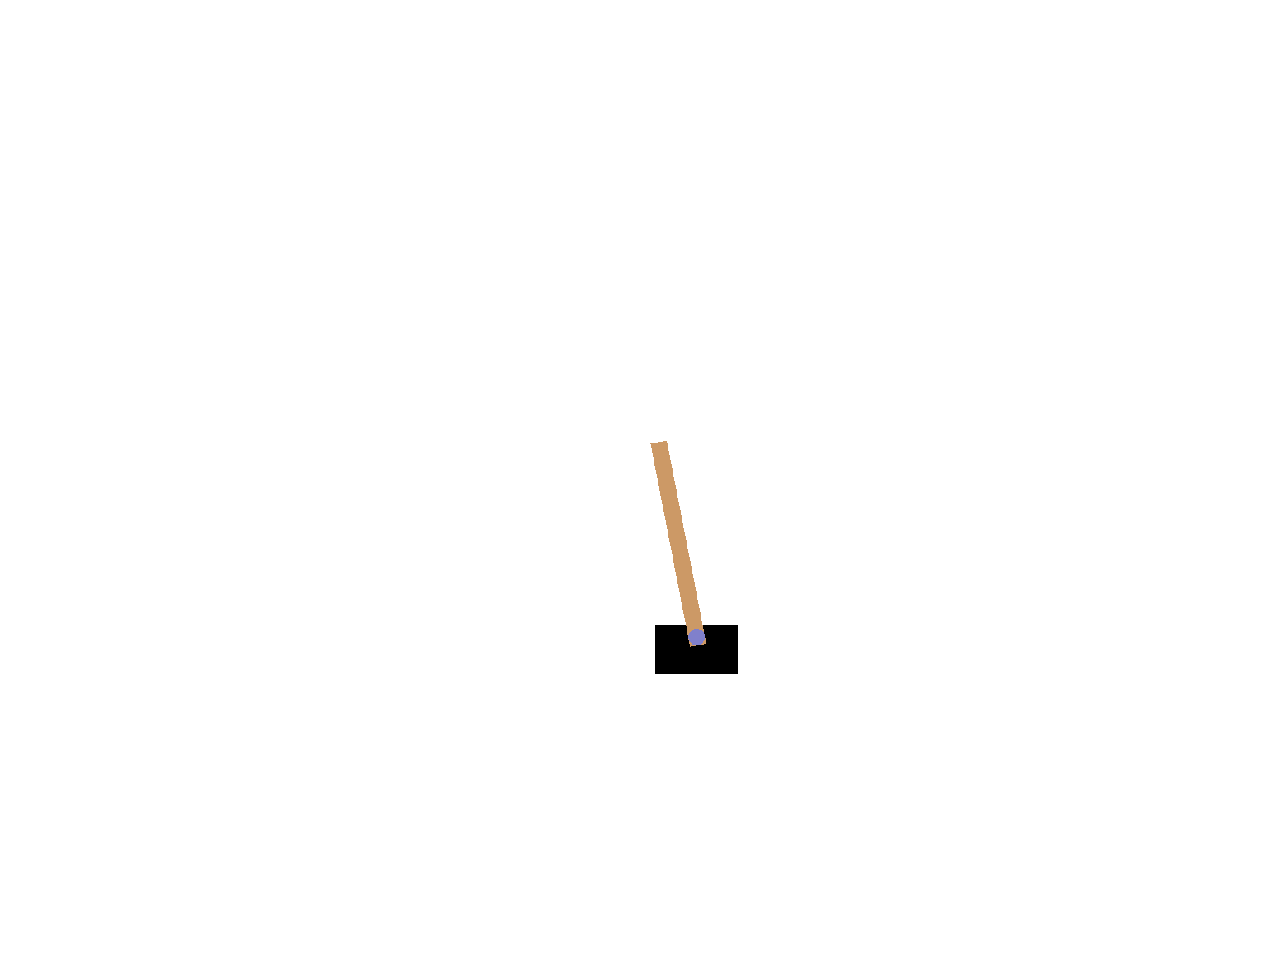

In [67]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own.

## Policy Gradients

To train this neural network we will need to define the target probabilities y. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in a game, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the credit assignment problem.
The Policy Gradients algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely. First we play, then we go back and think about what we did.